<a href="https://colab.research.google.com/github/layafakher/Bitcoin_Price_Prediction_Using_News_Sentiment_Analysis/blob/main/Bitcoin_Price_Prediction_Using_News_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install and Import Baseline Dependencies

In [ ]:
!pip install sentencepiece
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict

from datasets import Dataset
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score


import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 2. Collecting News from websites

## 2.1. Search for Bitcoin News using Google and Yahoo Finance

Google news scraper

In [ ]:
def getNewsData():
    min_time = "12/10/2021"  # Example minimum time (format: mm/dd/yyyy)
    max_time = "10/11/2022"  # Example maximum time (format: mm/dd/yyyy)
    encoded_time_range = urllib.parse.quote(f"cdr:1,cd_min:{min_time},cd_max:{max_time}")
    headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
    }
    response = requests.get(
        # "https://www.google.com/search?q=btc&tbm=nws&tbs=cdr:1,cd_min:3/2/2021,cd_max:6/5/2022&num=100000", headers=headers
        "https://www.google.com/search?q=bitcoin&sca_esv=557804163&biw=1536&bih=726&sxsrf=AB5stBhkg1Qk4CtFVV9nMCHbMYuspskBaQ%3A1692296805786&source=lnt&tbs=cdr%3A1%2Ccd_min%3A10%2F12%2F2021%2Ccd_max%3A11%2F10%2F2022&tbm=nws", headers=headers
    )

    soup = BeautifulSoup(response.content, "html.parser")
    news_results = []
    for el in soup.select("div.SoaBEf"):
        news_results.append(
            {
                "link": el.find("a")["href"],
                "title": el.select_one("div.MBeuO").get_text(),
                "snippet": el.select_one(".GI74Re").get_text(),
                "date": el.select_one(".LfVVr").get_text(),
                "source": el.select_one(".NUnG9d span").get_text()
            }
        )

    print(json.dumps(news_results, indent=2))

getNewsData()

[
  {
    "link": "https://www.reuters.com/technology/bitcoin-nears-record-high-ahead-futures-etf-listing-2021-10-19/",
    "title": "U.S. futures-based bitcoin ETF rises in first day of trading ...",
    "snippet": "Bitcoin, the world's largest cryptocurrency, is notoriously volatile, and \nhas risen around 45% this month on hopes that the advent of U.S. bitcoin \nETFs -...",
    "date": "19 Oct 2021",
    "source": "Reuters"
  },
  {
    "link": "https://www.cnbc.com/2021/10/19/first-bitcoin-futures-etf-rises-2percent-in-trading-debut.html",
    "title": "First bitcoin futures ETF rises more than 4% in trading debut on the NYSE",
    "snippet": "The fund tracks CME bitcoin futures, or contracts speculating on the future \nprice of bitcoin, rather than the crypto itself. That means investors in \nthe ETF...",
    "date": "19 Oct 2021",
    "source": "CNBC"
  },
  {
    "link": "https://www.ft.com/content/7b219639-dccd-4a4b-ad37-b8701df22db6",
    "title": "Bitcoin ETF rules leave UK i

Yahoo news scraper

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
# Define the keyword to search.
start_date = "2021-10-12"  # Replace with your desired start date
end_date = "2022-11-10"    # Replace with your desired end date
monitored_tickers = ['BTC','bitcoin','blockchain','altcoin','defi','ethereum','nft']
# Format the dates
formatted_start_date = datetime.strptime(start_date, "%Y-%m-%d").strftime("%s")
formatted_end_date = datetime.strptime(end_date, "%Y-%m-%d").strftime("%s")

keyword = 'btc'
news_data = []
for page in (0,21,41,60):
    # url = 'https://news.search.yahoo.com/search?q={}&b={}'.format(keyword,page)
    # url = 'https://news.search.yahoo.com/search?q={}&t={}-{}'.format(keyword, formatted_start_date, formatted_end_date)
    url = 'https://news.search.yahoo.com/search?q={}&tbs=cdr:1,cd_min:3/2/2021,cd_max:6/5/2022'.format(keyword)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    for news_item in soup.find_all('div', class_='NewsArticle'):
        news_title = news_item.find('h4').text
        news_source = news_item.find('span','s-source').text
        news_description = news_item.find('p','s-desc').text
        news_link = news_item.find('a').get('href')
        news_time = news_item.find('span', class_='fc-2nd').text
        # Perform basic clean text.
        news_time = news_time.replace('·', '').strip()
        news_title = news_title.replace('•', '').strip()
        news_data.append([news_title, news_source, news_description, news_link, news_time])

news_data_df = pd.DataFrame(news_data, columns=['Title','Source','Description','Link','Time'])

In [ ]:
news_data_df

,Title,Source,Description,Link,Time
0,Bitcoin support levels to watch as BTC price a...,The Cointelegraph,"Bitcoin bulls should be able to defend $28,000...",https://cointelegraph.com/news/bitcoin-support...,4 hours ago
1,Bitcoin bulls risk trading range loss as BTC p...,The Cointelegraph,"Bitcoin falls on Fed minutes, inflation outloo...",https://cointelegraph.com/news/bitcoin-bulls-r...,9 hours ago
2,BTC price won’t hit $100K before 2024 halving ...,The Cointelegraph,Bitcoin (BTC) will only hit six figures after ...,https://cointelegraph.com/news/btc-price-predi...,2 days ago
3,First Mover Americas: Bitcoin Drops to Lowest ...,CoinDesk via Yahoo Finance,The latest price moves in bitcoin (BTC) and cr...,https://finance.yahoo.com/news/first-mover-ame...,5 hours ago
4,BTC price breakout by end of August? 5 things ...,The Cointelegraph,Bitcoin (BTC) is painting a classic August pic...,https://cointelegraph.com/news/btc-price-break...,3 days ago
5,"Top 3 Price Prediction Bitcoin, Ethereum, Ripp...",The Forex Market,Bitcoin price coils up for a big move and coul...,https://www.fxstreet.com/cryptocurrencies/news...,17 hours ago
6,Crypto Investors Can Now Trade XRP Options on ...,CoinDesk via Yahoo Finance,Institutional liquidity provider OrBit Markets...,https://finance.yahoo.com/news/crypto-investor...,6 hours ago
7,4 Cryptocurrency Stocks to Watch as Market Vol...,Zacks via Yahoo Finance,More rate hikes could adversely impact the cry...,https://finance.yahoo.com/news/4-cryptocurrenc...,6 hours ago
8,Bitcoin soars in Argentina as Javier Milei win...,The Cointelegraph,The price of Bitcoin (BTC) has jumped to a fre...,https://cointelegraph.com/news/bitcoin-hits-re...,6 hours ago
9,Bitcoin and Ether now less volatile than oil: ...,The Cointelegraph,The Bitcoin (BTC) and Ether (ETH) 90-day price...,https://cointelegraph.com/news/bitcoin-btc-eth...,5 hours ago


# 3. Read news DataSet


## **3.1. Reading data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

drive_path = "/content/gdrive/My Drive/BTC_Price_Prediction"

Mounted at /content/gdrive


In [ ]:
import pandas
# data = pandas.read_csv('/content/gdrive/My Drive/BTC_Price_Prediction/cryptonews.csv',dtype={'sentiment': 'str'})
data = pandas.read_csv('/content/gdrive/My Drive/BTC_Price_Prediction/cryptonews3.csv')
data



,date,source,subject,text,title,url
0,11/15/2022 11:00,CoinTelegraph,blockchain,With a roster full of entertainment industry n...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...
1,11/15/2022 10:55,CoinTelegraph,bitcoin,Blockchain analytics firm Nansen has released ...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...
2,11/15/2022 10:32,CoinTelegraph,bitcoin,The hardware wallet firm is certain that the l...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...
3,11/15/2022 9:56,CryptoNews,blockchain,"Kyle Davies, founder of the collapsed crypto f...",Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...
4,11/15/2022 9:46,CryptoNews,blockchain,Despite the ongoing crypto market downturn whi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...
...,...,...,...,...,...,...
12745,10/27/2021 15:17,CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...
12746,10/19/2021 13:39,CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...
12747,10/18/2021 13:58,CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...
12748,10/15/2021 0:00,CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...


#### **3.2. Pre-processing**
#### Data cleaning:
* Remove punctuation.
* Remove stop word.
* Normalize (by applying a Stemmer or a Lemmatizer ).
* Set all characters to lowercase.
* Remove numbers (or convert numbers to * textual representations).


Cleaning the text

In [ ]:
# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
data['text'] = data['text'].apply(clean)
data.head()

,date,source,subject,text,title,url
0,11/15/2022 11:00,CoinTelegraph,blockchain,With a roster full of entertainment industry n...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...
1,11/15/2022 10:55,CoinTelegraph,bitcoin,Blockchain analytics firm Nansen has released ...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...
2,11/15/2022 10:32,CoinTelegraph,bitcoin,The hardware wallet firm is certain that the l...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...
3,11/15/2022 9:56,CryptoNews,blockchain,Kyle Davies founder of the collapsed crypto fu...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...
4,11/15/2022 9:46,CryptoNews,blockchain,Despite the ongoing crypto market downturn whi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...


removing links

lowering the words

In [ ]:
data['text']= data['text'].apply(lambda x: x.lower())
data

,date,source,subject,text,title,url
0,11/15/2022 11:00,CoinTelegraph,blockchain,with a roster full of entertainment industry n...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...
1,11/15/2022 10:55,CoinTelegraph,bitcoin,blockchain analytics firm nansen has released ...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...
2,11/15/2022 10:32,CoinTelegraph,bitcoin,the hardware wallet firm is certain that the l...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...
3,11/15/2022 9:56,CryptoNews,blockchain,kyle davies founder of the collapsed crypto fu...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...
4,11/15/2022 9:46,CryptoNews,blockchain,despite the ongoing crypto market downturn whi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...
...,...,...,...,...,...,...
12745,10/27/2021 15:17,CryptoNews,defi,cream finance cream suffered another flash loa...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...
12746,10/19/2021 13:39,CryptoNews,blockchain,banque de france disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...
12747,10/18/2021 13:58,CryptoNews,blockchain,advancing its project to become x ca xa metave...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...
12748,10/15/2021 0:00,CryptoNews,blockchain,chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...


removing stop words

In [ ]:
stop_words = set(stopwords.words('english'))

# Define a function to remove stop words from a sentence
def remove_stop_words(sentence):
  # Split the sentence into individual words
  words = sentence.split()

  # Use a list comprehension to remove stop words
  filtered_words = [word for word in words if word not in stop_words]

  # Join the filtered words back into a sentence
  return ' '.join(filtered_words)


data['text'] = data['text'].apply(remove_stop_words)

Normalization
(lemmatization)

In [ ]:
lemmatizer = WordNetLemmatizer()
def normalize(sentence):
  words = sentence.split()
  lemma_words=[lemmatizer.lemmatize(w) for w in words]
  return ' '.join(lemma_words)

data['text'] = data['text'].apply(normalize)
data

,date,source,subject,text,title,url
0,11/15/2022 11:00,CoinTelegraph,blockchain,roster full entertainment industry notable aet...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...
1,11/15/2022 10:55,CoinTelegraph,bitcoin,blockchain analytics firm nansen released over...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...
2,11/15/2022 10:32,CoinTelegraph,bitcoin,hardware wallet firm certain latest uptick dem...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...
3,11/15/2022 9:56,CryptoNews,blockchain,kyle davy founder collapsed crypto fund three ...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...
4,11/15/2022 9:46,CryptoNews,blockchain,despite ongoing crypto market downturn intensi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...
...,...,...,...,...,...,...
12745,10/27/2021 15:17,CryptoNews,defi,cream finance cream suffered another flash loa...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...
12746,10/19/2021 13:39,CryptoNews,blockchain,banque de france disclosed result experimental...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...
12747,10/18/2021 13:58,CryptoNews,blockchain,advancing project become x ca xa metaverse xa ...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...
12748,10/15/2021 0:00,CryptoNews,blockchain,chinese company still topping blockchain paten...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...


# 4. Adding Sentiment Analysis

## 4.1. VADER

In [ ]:
!pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [ ]:
def row_sentiment_analysis(row):
  print(row)
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(row)
  row["Neutral"] = sentiment_dict['neu']
  row["Negetive"] = sentiment_dict['neg']
  row["Positive"] = sentiment_dict['pos']
  return row

In [ ]:
analyzer = SentimentIntensityAnalyzer()
text = data['title']
data['compound'] = [analyzer.polarity_scores(x)['compound'] for x in text]
data['neg'] = [analyzer.polarity_scores(x)['neg'] for x in text]
data['neu'] = [analyzer.polarity_scores(x)['neu'] for x in text]
data['pos'] = [analyzer.polarity_scores(x)['pos'] for x in text]



In [ ]:
text[0]

'Trezor reports 300% surge in sales revenue due to FTX contagion.The hardware wallet firm is certain that the latest uptick in demand is a result of investors rescuing their funds in the aftermath of the FTX failure.'

In [ ]:
data

,date,source,subject,text,title,url,compound,neg,neu,pos
0,11/15/2022 10:32,CoinTelegraph,bitcoin,The hardware wallet firm is certain that the l...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...,-0.4588,0.231,0.769,0.000
1,11/15/2022 9:39,CoinTelegraph,bitcoin,Sale price versus price paid diverges the most...,BTC losses get real as Bitcoin SOPR metric hit...,https://cointelegraph.com/news/btc-losses-get-...,-0.6486,0.325,0.675,0.000
2,11/15/2022 7:39,CryptoPotato,bitcoin,Bitcoin and crypto investors are becoming incr...,Bitcoin Hodlers Make Self-Custody Moves After ...,https://cryptopotato.com/bitcoin-hodlers-make-...,-0.5106,0.320,0.680,0.000
3,11/15/2022 5:47,CryptoNews,bitcoin,"On November 15,Â\xa0BitcoinÂ\xa0bounced off a ...","Bitcoin Price and Ethereum Hold Strong, Cronos...",https://cryptonews.com/news/bitcoin-price-ethe...,0.5106,0.000,0.708,0.292
4,11/15/2022 4:24,CryptoNews,bitcoin,On Monday Edward Snowden tweeted 'for the firs...,Will Edward Snowden's New Bitcoin Price Predic...,https://cryptonews.com/news/will-edward-snowde...,0.0000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...
4815,11/11/2021 9:07,CryptoNews,bitcoin,The latest announcement appears part of a coor...,Twitter Launches Twitter Crypto: Here's How th...,https://cryptonews.com/news/twitter-launches-t...,0.0000,0.000,1.000,0.000
4816,11/10/2021 15:37,CryptoNews,bitcoin,Bitcoin (BTC) hit yet another all-time high on...,Bitcoin Hits All-Time High on Record US Inflat...,https://cryptonews.com/news/bitcoin-hits-all-t...,0.0000,0.000,1.000,0.000
4817,11/10/2021 13:10,CryptoNews,bitcoin,Bitcoin price is struggling to gain momentum f...,Bitcoin and Ethereum Prepare For Next Move,https://cryptonews.com/news/bitcoin-and-ethere...,0.0000,0.000,1.000,0.000
4818,11/10/2021 11:09,CryptoNews,bitcoin,The much-awaited wallet is scheduled to be lau...,Robinhood Crypto Wallet Waitlist Attracts 1.6M...,https://cryptonews.com/news/robinhood-crypto-w...,0.4019,0.000,0.690,0.310


## 4.2. TextBlob

In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from textblob import TextBlob


In [ ]:
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

In [ ]:
def analysis(score):
    if score < 0:
        return -1
    elif score == 0:
        return 0
    else:
        return 1

In [ ]:

# text = data['title'] +"." + data['text']
text = data['text']
data['Subjectivity'] = text.apply(getSubjectivity)
data['Polarity'] = text.apply(getPolarity)
data['Analysis'] = data['Polarity'].apply(analysis)
data

,date,source,subject,text,title,url,Subjectivity,Polarity,Analysis
0,11/15/2022 11:00,CoinTelegraph,blockchain,roster full entertainment industry notable aet...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...,0.362500,0.112500,1
1,11/15/2022 10:55,CoinTelegraph,bitcoin,blockchain analytics firm nansen released over...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...,0.450000,-0.068750,-1
2,11/15/2022 10:32,CoinTelegraph,bitcoin,hardware wallet firm certain latest uptick dem...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...,0.542857,0.049405,1
3,11/15/2022 9:56,CryptoNews,blockchain,kyle davy founder collapsed crypto fund three ...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...,0.000000,0.000000,0
4,11/15/2022 9:46,CryptoNews,blockchain,despite ongoing crypto market downturn intensi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...,0.386310,0.127381,1
...,...,...,...,...,...,...,...,...,...
12745,10/27/2021 15:17,CryptoNews,defi,cream finance cream suffered another flash loa...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,0.000000,0.000000,0
12746,10/19/2021 13:39,CryptoNews,blockchain,banque de france disclosed result experimental...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,0.400000,0.100000,1
12747,10/18/2021 13:58,CryptoNews,blockchain,advancing project become x ca xa metaverse xa ...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,0.498182,0.265455,1
12748,10/15/2021 0:00,CryptoNews,blockchain,chinese company still topping blockchain paten...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0.000000,0.000000,0


##4.3. Exporting Results to CSV

In [ ]:
import csv
data.to_csv('/content/gdrive/My Drive/BTC_Price_Prediction/news_result_sentimentAnalysis.csv')

# 5. Getting Bitcoin Data

In [ ]:
!pip install finnhub-python

In [ ]:
import finnhub
import pandas as pd
import calendar as cal
from datetime import datetime, timedelta, time
import numpy as np

In [ ]:
def get_crypto_data(finnhub_client, start, finish, span, symbol):
    result = pd.DataFrame()
    timspan = finish - start

    if span == 'D':
      total_span_seconds = 24 * 60 * 60
    else :
      total_span_seconds = span * 60

    total_time_seconds = timspan.total_seconds()
    interval = int(total_time_seconds / (total_span_seconds * 1000)) + 1
    for i in range(interval):
        start_time = start + timedelta(seconds = total_span_seconds * i * 1000)
        finish_time = start + timedelta(seconds = total_span_seconds * (i + 1) * 1000)
        if(finish_time > finish):
            finish_time = finish
        start_time_int = cal.timegm(start_time.timetuple())
        finish_time_int = cal.timegm(finish_time.timetuple())
        res = finnhub_client.crypto_candles(f'BINANCE:{symbol}', str(span), start_time_int, finish_time_int)
        res = pd.DataFrame(res)
        result = pd.concat([result, res])
        result.reset_index(drop=True, inplace=True)
    return result[:-1]

In [ ]:
def convert_to_dateTime(row):
    return datetime.fromtimestamp(row['DateTime']).strftime("%Y-%m-%d %H:%M:%S")[:-6]

In [ ]:
finnhub_client = finnhub.Client(api_key="citqh1hr01qu27mo2p9gcitqh1hr01qu27mo2pa0")

time_span = 60
num_of_candles = 365 * 24
# finish_time = datetime.combine(datetime.today(), time.min)
finish_time = datetime.strptime('16112022', '%d%m%Y').date()
if time_span == 'D':
  start_time = finish_time - timedelta(seconds = num_of_candles * 24 * 60 * 60)
else :
  start_time = finish_time - timedelta(seconds = num_of_candles * time_span * 60)

In [ ]:
crypto_df = get_crypto_data(finnhub_client, start_time, finish_time, time_span, 'BTCUSDT')
crypto_df.rename(columns={'c': 'Close', 'h': 'High', 'l': 'Low', 'o': 'Open', 't': 'DateTime', 'v': 'Volume'}, inplace=True)
crypto_df.drop(['s'], axis=1, inplace=True)
crypto_df['DateTime'] = crypto_df.apply(lambda row : convert_to_dateTime(row), axis=1)
crypto_df.loc[0, 'Change%'] = 0.0
crypto_df['Range%'] = (crypto_df['High'] - crypto_df['Low']) * 100 / crypto_df['Close']
for i in range(1,len(crypto_df)):
  crypto_df.loc[i,"Change%"] = (crypto_df.loc[i,"Close"] - crypto_df.loc[i - 1,"Close"]) * 100 / crypto_df.loc[i - 1,"Close"]

In [ ]:
crypto_df

,Close,High,Low,Open,DateTime,Volume,Change%,Range%
0,62540.03,63617.31,62462.91,63606.73,2021-11-16 00,4765.15100,0.000000,1.845858
1,62110.10,62636.16,60980.00,62540.02,2021-11-16 01,7766.01382,-0.687448,2.666491
2,61620.62,62206.80,61500.00,62110.09,2021-11-16 02,2064.41123,-0.788084,1.147019
3,60907.41,61806.95,60422.20,61620.62,2021-11-16 03,5486.38687,-1.157421,2.273533
4,61211.43,61600.00,60322.20,60907.40,2021-11-16 04,4081.02324,0.499151,2.087519
...,...,...,...,...,...,...,...,...
8726,16858.77,16878.83,16614.61,16733.00,2022-11-15 19,14664.03422,0.742417,1.567255
8727,16839.81,16939.99,16736.47,16858.77,2022-11-15 20,11334.67417,-0.112464,1.208565
8728,16911.12,16929.98,16778.21,16839.81,2022-11-15 21,8463.11239,0.423461,0.897457
8729,16880.49,16913.56,16844.39,16911.10,2022-11-15 22,4819.50077,-0.181123,0.409763


In [ ]:
from os.path import isfile, join


In [ ]:
crypto_df['24h_change%'] = crypto_df['Close'].diff(24) * 100 / crypto_df.loc[i - 1,"Close"]
crypto_df.to_excel(join(drive_path,f'crypto_data_2022-11-15_2021-11-16.xlsx'), index=False)

# 6. Combining Data


Read news from

In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/BTC_Price_Prediction/news_result_sentimentAnalysis.csv")

Read bitcoin data

In [ ]:
crypto_df = pd.read_excel("/content/gdrive/My Drive/BTC_Price_Prediction/crypto_data_2022-11-15_2021-11-16.xlsx")

Combining data using left joing and fixing NaN values and empty sentiment values.

In [ ]:
from datetime import datetime, timedelta, time


In [ ]:
def format_date(row):
  d = datetime.strptime(row['date'], '%m/%d/%Y %H:%M')
  return d.strftime("%Y-%m-%d %H:%M:%S")[:-6]

In [ ]:
data

,Unnamed: 0,date,source,subject,text,title,url,Subjectivity,Polarity,Analysis
0,0,11/15/2022 11:00,CoinTelegraph,blockchain,roster full entertainment industry notable aet...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...,0.362500,0.112500,1
1,1,11/15/2022 10:55,CoinTelegraph,bitcoin,blockchain analytics firm nansen released over...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...,0.450000,-0.068750,-1
2,2,11/15/2022 10:32,CoinTelegraph,bitcoin,hardware wallet firm certain latest uptick dem...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...,0.542857,0.049405,1
3,3,11/15/2022 9:56,CryptoNews,blockchain,kyle davy founder collapsed crypto fund three ...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...,0.000000,0.000000,0
4,4,11/15/2022 9:46,CryptoNews,blockchain,despite ongoing crypto market downturn intensi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...,0.386310,0.127381,1
...,...,...,...,...,...,...,...,...,...,...
12745,12745,10/27/2021 15:17,CryptoNews,defi,cream finance cream suffered another flash loa...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,0.000000,0.000000,0
12746,12746,10/19/2021 13:39,CryptoNews,blockchain,banque de france disclosed result experimental...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,0.400000,0.100000,1
12747,12747,10/18/2021 13:58,CryptoNews,blockchain,advancing project become x ca xa metaverse xa ...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,0.498182,0.265455,1
12748,12748,10/15/2021 0:00,CryptoNews,blockchain,chinese company still topping blockchain paten...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0.000000,0.000000,0


In [ ]:
data['DateTime'] = data.apply(lambda x:format_date(x), axis=1)


In [ ]:
data

,Unnamed: 0,date,source,subject,text,title,url,Subjectivity,Polarity,Analysis,DateTime
0,0,11/15/2022 11:00,CoinTelegraph,blockchain,roster full entertainment industry notable aet...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...,0.362500,0.112500,1,2022-11-15 11
1,1,11/15/2022 10:55,CoinTelegraph,bitcoin,blockchain analytics firm nansen released over...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...,0.450000,-0.068750,-1,2022-11-15 10
2,2,11/15/2022 10:32,CoinTelegraph,bitcoin,hardware wallet firm certain latest uptick dem...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...,0.542857,0.049405,1,2022-11-15 10
3,3,11/15/2022 9:56,CryptoNews,blockchain,kyle davy founder collapsed crypto fund three ...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...,0.000000,0.000000,0,2022-11-15 09
4,4,11/15/2022 9:46,CryptoNews,blockchain,despite ongoing crypto market downturn intensi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...,0.386310,0.127381,1,2022-11-15 09
...,...,...,...,...,...,...,...,...,...,...,...
12745,12745,10/27/2021 15:17,CryptoNews,defi,cream finance cream suffered another flash loa...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,0.000000,0.000000,0,2021-10-27 15
12746,12746,10/19/2021 13:39,CryptoNews,blockchain,banque de france disclosed result experimental...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,0.400000,0.100000,1,2021-10-19 13
12747,12747,10/18/2021 13:58,CryptoNews,blockchain,advancing project become x ca xa metaverse xa ...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,0.498182,0.265455,1,2021-10-18 13
12748,12748,10/15/2021 0:00,CryptoNews,blockchain,chinese company still topping blockchain paten...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0.000000,0.000000,0,2021-10-15 00


In [ ]:
data = data.drop(['date'], axis = 1)

In [ ]:
data

,Unnamed: 0,source,subject,text,title,url,Subjectivity,Polarity,Analysis,DateTime
0,0,CoinTelegraph,blockchain,roster full entertainment industry notables ae...,Aether Games Sets Sights on Dark Fantasy DeFi ...,https://cointelegraph.com/news/aether-games-se...,0.275000,0.175000,1,2022-11-15 11
1,1,CoinTelegraph,bitcoin,blockchain analytics firm nansen released over...,FTX debacle sees Nansen take stock of major ex...,https://cointelegraph.com/news/ftx-debacle-see...,0.450000,-0.068750,-1,2022-11-15 10
2,2,CoinTelegraph,bitcoin,hardware wallet firm certain latest uptick dem...,Trezor reports 300% surge in sales revenue due...,https://cointelegraph.com/news/trezor-reports-...,0.542857,0.049405,1,2022-11-15 10
3,3,CryptoNews,blockchain,kyle davies founder collapsed crypto fund thre...,Defunct Billion-Dollar Crypto Hedge Fund Three...,https://cryptonews.com/news/defunct-billion-do...,0.000000,0.000000,0,2022-11-15 09
4,4,CryptoNews,blockchain,despite ongoing crypto market downturn intensi...,Billionaire Mark Cuban Still Believes in Crypt...,https://cryptonews.com/news/billionaire-mark-c...,0.386310,0.127381,1,2022-11-15 09
...,...,...,...,...,...,...,...,...,...,...
12745,12745,CryptoNews,defi,cream finance cream suffered another flash loa...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,0.000000,0.000000,0,2021-10-27 15
12746,12746,CryptoNews,blockchain,banque de france disclosed results experimenta...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,0.400000,0.100000,1,2021-10-19 13
12747,12747,CryptoNews,blockchain,advancing project become x ca xa metaverse xa ...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,0.498182,0.265455,1,2021-10-18 13
12748,12748,CryptoNews,blockchain,chinese companies still topping blockchain pat...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0.000000,0.000000,0,2021-10-15 00


In [ ]:
df_news = data.groupby(['DateTime']).agg(Subjectivity=('Subjectivity', 'mean'),
                                         Polarity=('Polarity', 'mean'),
                                         Analysis=('Analysis','max'),
                                         Total=('Analysis','count'),
                                         ).reset_index()


In [ ]:
df_news

,DateTime,Subjectivity,Polarity,Analysis,Total
0,2021-10-12 20,0.500000,-0.187500,-1,1
1,2021-10-15 00,0.000000,0.000000,0,1
2,2021-10-18 13,0.498182,0.265455,1,1
3,2021-10-19 13,0.400000,0.100000,1,1
4,2021-10-27 15,0.000000,0.000000,0,1
...,...,...,...,...,...
5965,2022-11-15 07,0.538889,-0.016667,-1,1
5966,2022-11-15 08,0.100000,0.100000,1,1
5967,2022-11-15 09,0.212103,0.014683,1,3
5968,2022-11-15 10,0.496429,-0.009673,1,2


In [ ]:
from os.path import isfile, join


In [ ]:
df = pd.merge(crypto_df,df_news,on='DateTime',how='left')

df.fillna({'Neutral':1}, inplace=True)
df.fillna(0, inplace=True)

df.to_excel(join(drive_path,f'sentiment_analysis_dataset.xlsx'), index=False)

In [ ]:
df

,Close,High,Low,Open,DateTime,Volume,Change%,Range%,24h_change%,Subjectivity,Polarity,Analysis,Total
0,62540.03,63617.31,62462.91,63606.73,2021-11-16 00,4765.15100,0.000000,1.845858,0.000000,0.0,0.0,0.0,0.0
1,62110.10,62636.16,60980.00,62540.02,2021-11-16 01,7766.01382,-0.687448,2.666491,0.000000,0.0,0.0,0.0,0.0
2,61620.62,62206.80,61500.00,62110.09,2021-11-16 02,2064.41123,-0.788084,1.147019,0.000000,0.0,0.0,0.0,0.0
3,60907.41,61806.95,60422.20,61620.62,2021-11-16 03,5486.38687,-1.157421,2.273533,0.000000,0.0,0.0,0.0,0.0
4,61211.43,61600.00,60322.20,60907.40,2021-11-16 04,4081.02324,0.499151,2.087519,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8726,16858.77,16878.83,16614.61,16733.00,2022-11-15 19,14664.03422,0.742417,1.567255,3.557717,0.0,0.0,0.0,0.0
8727,16839.81,16939.99,16736.47,16858.77,2022-11-15 20,11334.67417,-0.112464,1.208565,3.346941,0.0,0.0,0.0,0.0
8728,16911.12,16929.98,16778.21,16839.81,2022-11-15 21,8463.11239,0.423461,0.897457,2.989783,0.0,0.0,0.0,0.0
8729,16880.49,16913.56,16844.39,16911.10,2022-11-15 22,4819.50077,-0.181123,0.409763,2.783865,0.0,0.0,0.0,0.0


Reading combined data set

In [ ]:
pip install xlrd

In [ ]:
df = pd.read_excel(join(drive_path,f'sentiment_analysis_dataset.xlsx'))

df

,Close,High,Low,Open,DateTime,Volume,Change%,Range%,24h_change%,Subjectivity,Polarity,Analysis,Total
0,62540.03,63617.31,62462.91,63606.73,2021-11-16 00,4765.15100,0.000000,1.845858,0.000000,0.0,0.0,0,0
1,62110.10,62636.16,60980.00,62540.02,2021-11-16 01,7766.01382,-0.687448,2.666491,0.000000,0.0,0.0,0,0
2,61620.62,62206.80,61500.00,62110.09,2021-11-16 02,2064.41123,-0.788084,1.147019,0.000000,0.0,0.0,0,0
3,60907.41,61806.95,60422.20,61620.62,2021-11-16 03,5486.38687,-1.157421,2.273533,0.000000,0.0,0.0,0,0
4,61211.43,61600.00,60322.20,60907.40,2021-11-16 04,4081.02324,0.499151,2.087519,0.000000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8726,16858.77,16878.83,16614.61,16733.00,2022-11-15 19,14664.03422,0.742417,1.567255,3.557717,0.0,0.0,0,0
8727,16839.81,16939.99,16736.47,16858.77,2022-11-15 20,11334.67417,-0.112464,1.208565,3.346941,0.0,0.0,0,0
8728,16911.12,16929.98,16778.21,16839.81,2022-11-15 21,8463.11239,0.423461,0.897457,2.989783,0.0,0.0,0,0
8729,16880.49,16913.56,16844.39,16911.10,2022-11-15 22,4819.50077,-0.181123,0.409763,2.783865,0.0,0.0,0,0


Plotting price per news

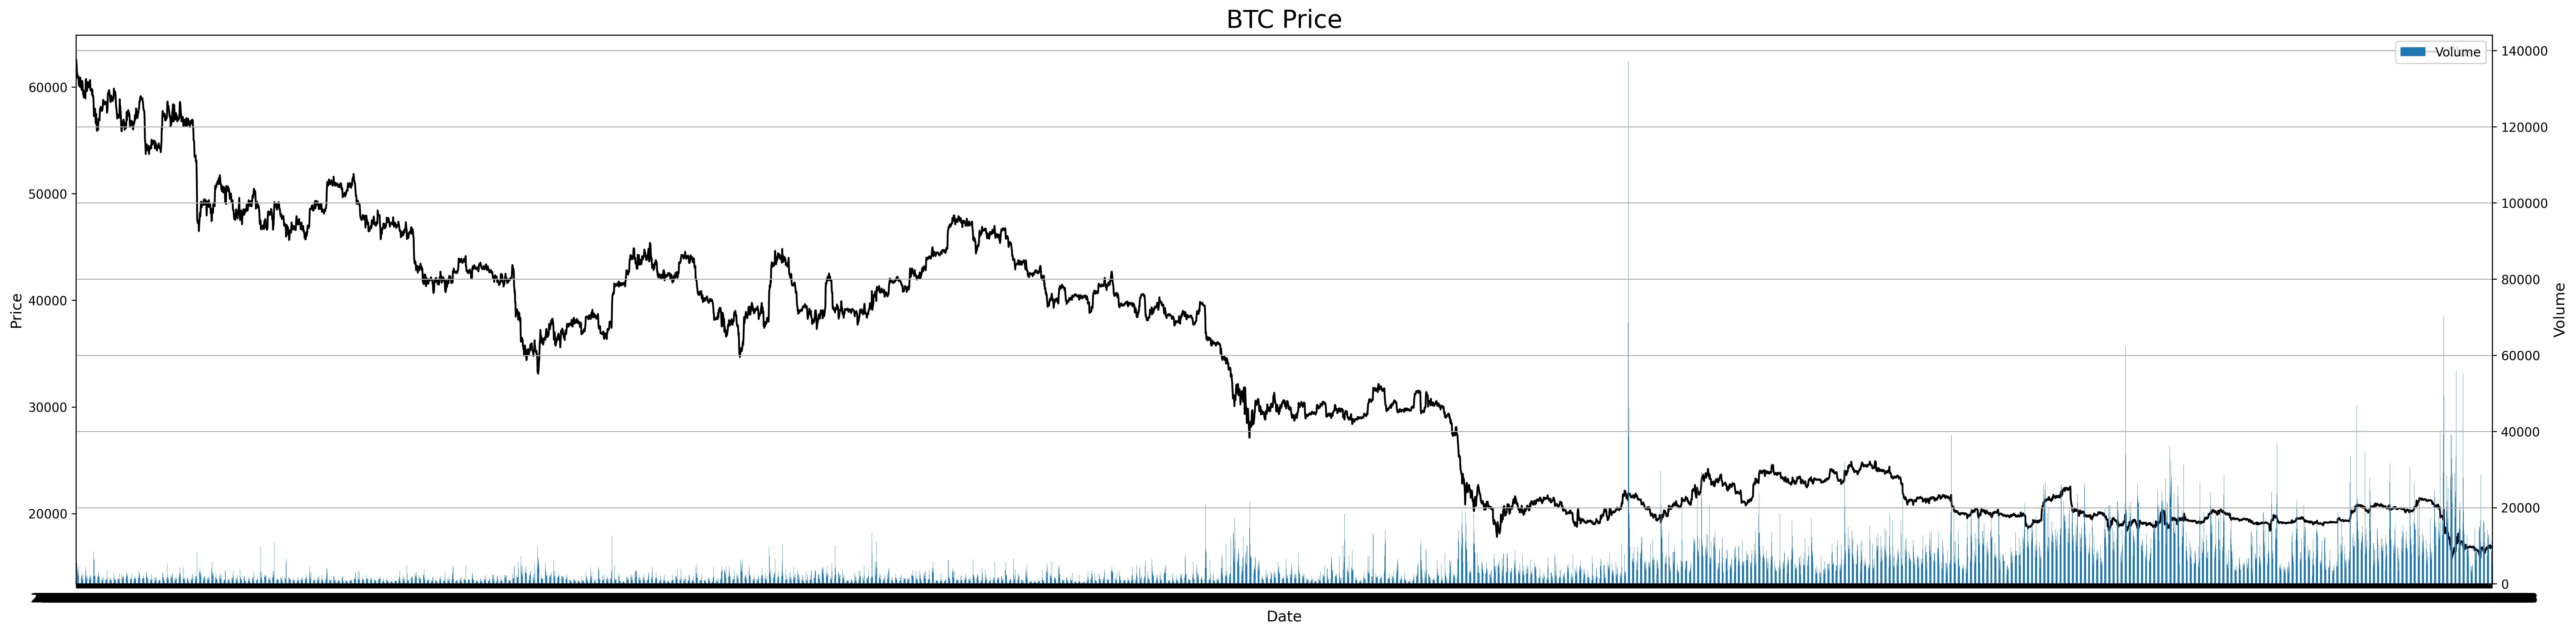

In [ ]:
df1 = df.copy()
df1.loc[df["Total"] == 0, "Total"] = np.nan

fig = plt.figure(figsize = (35,8), dpi=300)
crypto_df.plot(x="DateTime", y="Close", ax=plt.gca(), color='black')
ax = plt.gca()
ax1 = ax.twinx()
crypto_df.plot(x="DateTime", y="Volume", kind='bar', ax=ax1)
ax.set_ylabel('Price', fontsize = 12 )
ax.set_xlabel('Date', fontsize = 12 )
ax1.set_ylabel('Volume', fontsize = 12 )
plt.title('BTC Price', fontsize = 20)
ax.legend()
ax1.legend()
plt.grid()
plt.show()

# 7.Tensor Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os.path import join

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM

Setting model configurations. Our model uses one LSTM layer as it produces the best result. lock back is set to 5 days and the data is splitted in 80%/20% train and test.

In [ ]:
look_back = 24*5
num_units = 256
epochs=80
batch_size=128
train_test_split = 0.80

The dataset that we created in the last notebook is called here. The data is then scaled and the types are set to float32

In [ ]:
df = pd.read_excel(join(drive_path,f'sentiment_analysis_dataset.xlsx'))

In [ ]:
df1 = df.copy()
dateTime_col = df1[['DateTime']].copy()
df1 = df1.drop("DateTime", axis=1)

In [ ]:
df1

,Close,High,Low,Open,Volume,Change%,Range%,24h_change%,Subjectivity,Polarity,Analysis,Total
0,62540.03,63617.31,62462.91,63606.73,4765.15100,0.000000,1.845858,0.000000,0.0,0.0,0,0
1,62110.10,62636.16,60980.00,62540.02,7766.01382,-0.687448,2.666491,0.000000,0.0,0.0,0,0
2,61620.62,62206.80,61500.00,62110.09,2064.41123,-0.788084,1.147019,0.000000,0.0,0.0,0,0
3,60907.41,61806.95,60422.20,61620.62,5486.38687,-1.157421,2.273533,0.000000,0.0,0.0,0,0
4,61211.43,61600.00,60322.20,60907.40,4081.02324,0.499151,2.087519,0.000000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8726,16858.77,16878.83,16614.61,16733.00,14664.03422,0.742417,1.567255,3.557717,0.0,0.0,0,0
8727,16839.81,16939.99,16736.47,16858.77,11334.67417,-0.112464,1.208565,3.346941,0.0,0.0,0,0
8728,16911.12,16929.98,16778.21,16839.81,8463.11239,0.423461,0.897457,2.989783,0.0,0.0,0,0
8729,16880.49,16913.56,16844.39,16911.10,4819.50077,-0.181123,0.409763,2.783865,0.0,0.0,0,0


In [ ]:
dataset = df1.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
num_of_features = len(df1.columns)

This section creates windows for LSTM layers. windows' dimensions are (Lock_back, num_features)

In [ ]:
pred_col = df1.columns.get_loc('Close')

def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back , pred_col])
  return np.array(dataX), np.array(dataY)

Splitting dataset into train and test and creating windows

In [ ]:
train_set, test_set = np.split(dataset, [int(train_test_split *len(dataset))])

x_train, y_train = create_dataset(train_set, pred_col, look_back=look_back)
x_test, y_test = create_dataset(test_set, pred_col, look_back=look_back)

x_train = np.reshape(x_train, (x_train.shape[0], look_back, num_of_features))
x_test = np.reshape(x_test, (x_test.shape[0],look_back, num_of_features))

In [ ]:
print('Number of features', num_of_features)
print('Training dataset length ', len(train_set))
print('Testing dataset length ', len(test_set))

Number of features 12
Training dataset length  6984
Testing dataset length  1747


The code below creates the model. It has LSTM layer and a Dense layer. The Dense layer serves the purpose of generating a single number as the price prediction. It also uses Adam optimizer and mean_squared_error to calculate loss

In [ ]:
model = Sequential()
model.add(LSTM(num_units, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(x_train, y_train,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/80
38/38 [==============================] - 4s 32ms/step - loss: 0.0491 - val_loss: 0.0050
Epoch 2/80
38/38 [==============================] - 1s 19ms/step - loss: 0.0170 - val_loss: 0.0048
Epoch 3/80
38/38 [==============================] - 1s 20ms/step - loss: 5.1685e-04 - val_loss: 2.0192e-04
Epoch 4/80
38/38 [==============================] - 1s 20ms/step - loss: 3.0508e-04 - val_loss: 1.1612e-04
Epoch 5/80
38/38 [==============================] - 1s 21ms/step - loss: 2.2692e-04 - val_loss: 6.4055e-05
Epoch 6/80
38/38 [==============================] - 1s 21ms/step - loss: 2.4992e-04 - val_loss: 4.9356e-05
Epoch 7/80
38/38 [==============================] - 1s 21ms/step - loss: 2.4317e-04 - val_loss: 4.8026e-05
Epoch 8/80
38/38 [==============================] - 1s 20ms/step - loss: 3.2383e-04 - val_loss: 6.3241e-05
Epoch 9/80
38/38 [==============================] - 1s 19ms/step - loss: 4.3004e-04 - val_loss: 9.3354e-05
Epoch 10/80
38/38 [==============================] - 

Validation and Training losses are plotted against each other. As it can be seen, the model starts from a high loss at first few epochs; So the righ plot
shows the loss after 20 epochs to so the minor changes can be visualized.

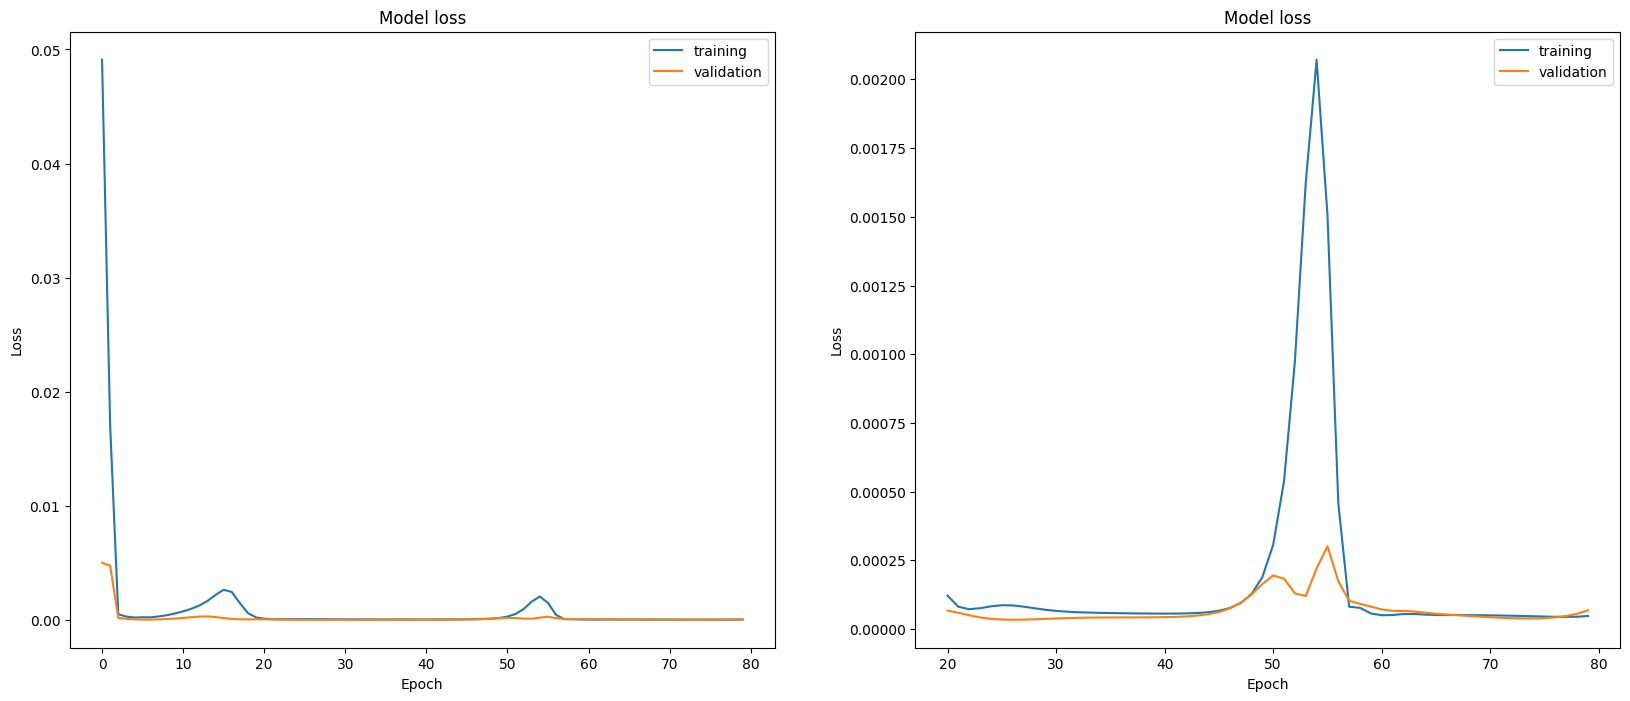

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

loss = history.history['loss']
val_loss = history.history['val_loss']

axis[0].plot(loss)
axis[0].plot(val_loss)
axis[0].set_title('Model loss')
axis[0].set_ylabel('Loss')
axis[0].set_xlabel('Epoch')
axis[0].legend(['training', 'validation'], loc='upper right')

axis[1].plot(np.arange(20, len(loss)), loss[20:])
axis[1].plot(np.arange(20, len(val_loss)), val_loss[20:])
axis[1].set_title('Model loss')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend(['training', 'validation'], loc='upper right')

plt.show()

Saving the model for later use

In [ ]:
model.save(join(drive_path,f'models/model_{look_back}_{num_units}.h5'))

In [ ]:
model = load_model(join(drive_path,f'models/model_72_256.h5'))

OSError: ignored

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

train_RMSE = mean_squared_error(y_train, trainPredict, squared=False)
test_RMSE = mean_squared_error(y_test, testPredict, squared=False)

train_MAE = mean_absolute_error(y_train, trainPredict)
test_MAE = mean_absolute_error(y_test, testPredict)

51/51 [==============================] - 0s 3ms/step


Inversing the price scaling to plot the data

In [ ]:
from scipy.ndimage import shift

In [ ]:
# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
temp =trainPredict[:,0]
# shift(temp, -7, cval=0)
# Put the predictions there
trainPredict_extended[:,pred_col] = temp
# Inverse transform it and select the 3rd column.
# trainPredict_extended[:,pred_col] = trainPredict_extended[:,pred_col].shift(-7)

trainPredict_scaled = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
t = testPredict[:,0]
# shift(t, -7, cval=0)
testPredict_extended[:,pred_col] = t
# Inverse transform it and select the pred_col column.
# testPredict_extended[:,pred_col] = testPredict_extended[:,pred_col].shift(-7)
testPredict_scaled = scaler.inverse_transform(testPredict_extended)[:,pred_col]

In [ ]:
len(testPredict_scaled)

1619

In [ ]:
dataset.dtype

dtype('float32')

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_scaled)+look_back, pred_col] = trainPredict_scaled

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_scaled)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict_scaled

# contruct pandas dataframe for plotting
actual_df = pd.DataFrame(scaler.inverse_transform(dataset)[:,pred_col],columns=['Actual'])
train_df = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
test_df = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
result_df = pd.concat([actual_df, train_df, test_df, dateTime_col], axis=1, sort=False)
result_df.set_index('DateTime',inplace=True)

Text(0, 0.5, 'BTC Price')

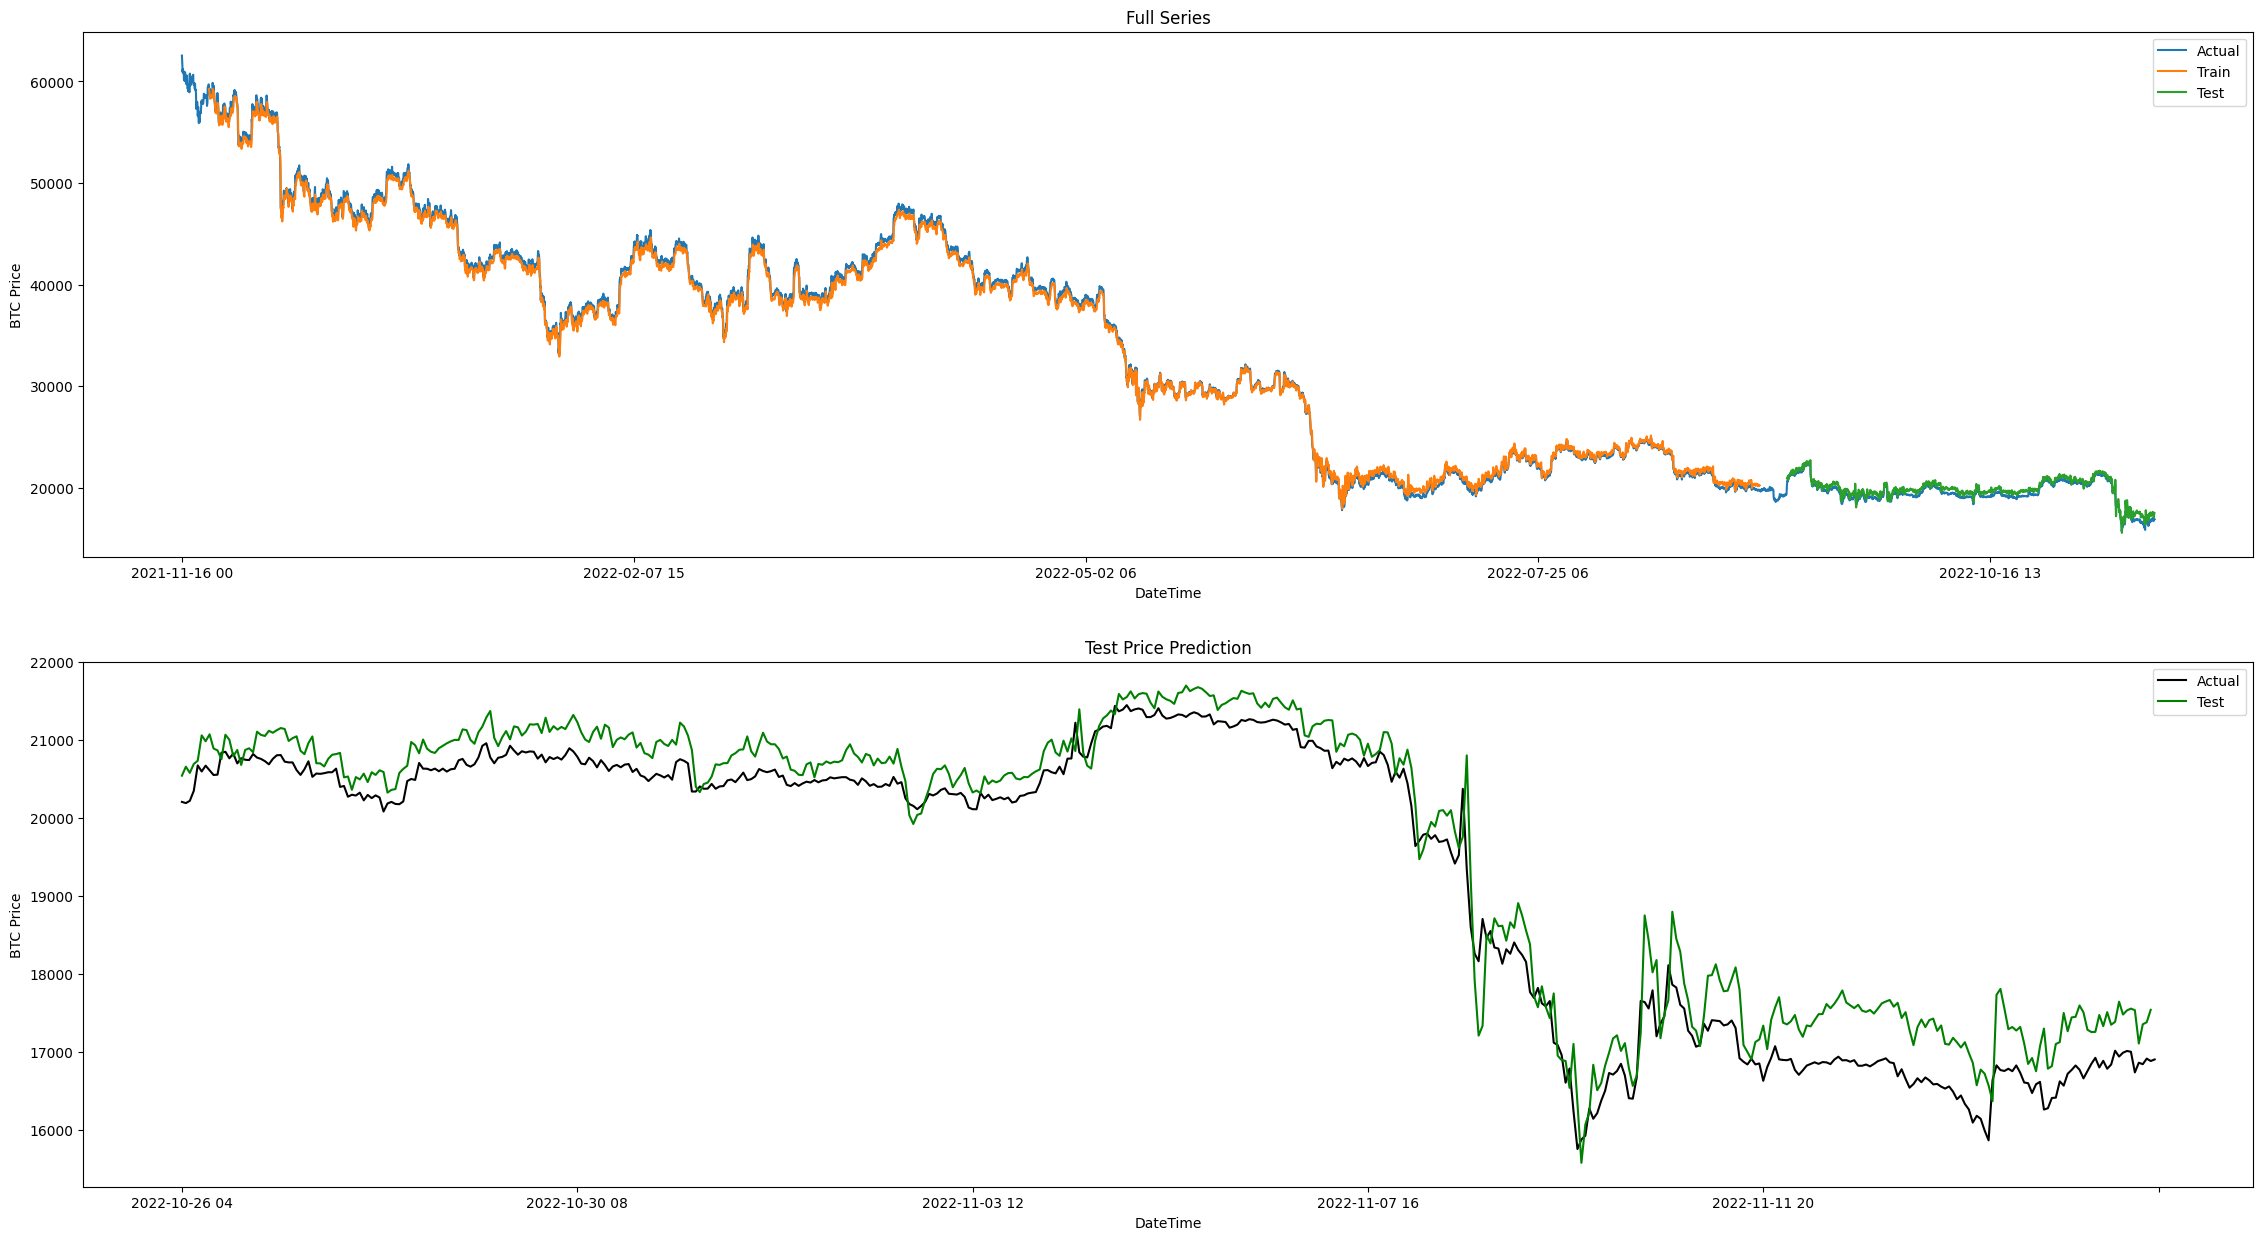

In [ ]:
figure, axis = plt.subplots(2, 1, figsize=(28,15))

result_df.plot(ax=axis[0])
axis[0].set_title('Full Series')
axis[0].set_ylabel('BTC Price')

result_df.drop(["Train"], axis=1).tail(500).plot(
    ax=axis[1], color=['black','g'])
axis[1].set_title('Test Price Prediction')
axis[1].set_ylabel('BTC Price')

In [ ]:
print('look_back days:', look_back/24)
print('num_units:', num_units)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(df1.columns))


print('-' * 50)
print('Train Score: %.5f RMSE' % (train_RMSE))
print('Test Score: %.5f RMSE' % (test_RMSE))

print('-' * 50)
print('Train Score: %.5f MAE' % (train_MAE))
print('Test Score: %.5f MAE' % (test_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

look_back days: 5.0
num_units: 256
epochs: 80
batch_size: 128
dataset features ['Close', 'High', 'Low', 'Open', 'Volume', 'Change%', 'Range%', '24h_change%', 'Subjectivity', 'Polarity', 'Analysis', 'Total']
--------------------------------------------------
Train Score: 0.01009 RMSE
Test Score: 0.00876 RMSE
--------------------------------------------------
Train Score: 0.00849 MAE
Test Score: 0.00783 MAE
--------------------------------------------------
Model summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               275456    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 275,713
Trainable params: 275,713
Non-trainable params: 0
___________________________________